In [66]:
import pandas as pd
import utils
import numpy as np
# from astropy.timeseries import BoxLeastSquares
import matplotlib.pyplot as plt
# import lightkurve as lk
from scipy.signal import medfilt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  

### Read in Lightcurve Data

#### Split into Train, Validation and Test (60/20/20)

In [32]:
# from csv file created using utils.collect_curves_tofiles()
# all_curves = pd.read_csv('./Data/flux_all_200_1000_50.csv', header = None)
# all_times = pd.read_csv('./Data/time_all_200_1000_50.csv', header = None)
# all_labels = pd.read_csv('./Data/labels_all_200_1000_50.csv', header = None)
all_curves = pd.read_csv('./Data/flux_all_1000_1000_50.csv', header = None)
all_times = pd.read_csv('./Data/time_all_1000_1000_50.csv', header = None)
all_labels = pd.read_csv('./Data/labels_all_1000_1000_50.csv', header = None)
all_labels = np.array(all_labels).ravel()

# train-val-test split 60-20-20 split
X_trainval, X_test, y_trainval, y_test = train_test_split(all_curves, all_labels, test_size=0.2, random_state=321)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=321)

# fill in Nans
X_train_interp = X_train.interpolate(limit_direction='both', axis = 1)
X_val_interp = X_val.interpolate(limit_direction='both', axis = 1)
X_test_interp = X_test.interpolate(limit_direction='both', axis = 1)

#### Split into Train and Test (80/20)

In [39]:
# from csv file created using utils.collect_curves_tofiles()
all_curves = pd.read_csv('./Data/flux_all_200_1000_50.csv', header = None)
all_times = pd.read_csv('./Data/time_all_200_1000_50.csv', header = None)
all_labels = pd.read_csv('./Data/labels_all_200_1000_50.csv', header = None)
# all_curves = pd.read_csv('./Data/flux_all_1000_1000_50.csv', header = None)
# all_times = pd.read_csv('./Data/time_all_1000_1000_50.csv', header = None)
# all_labels = pd.read_csv('./Data/labels_all_1000_1000_50.csv', header = None)
all_labels = np.array(all_labels).ravel()

X_train, X_test, y_train, y_test = train_test_split(all_curves, all_labels, test_size=0.2, random_state=321)

# fill in Nans
X_train_interp = X_train.interpolate(limit_direction='both', axis = 1)
X_test_interp = X_test.interpolate(limit_direction='both', axis = 1)

### Using SVC with default params

In [33]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train_interp, y_train.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [34]:
svc_pred_val = clf.predict(X_val_interp)
svc_pred_train = clf.predict(X_train_interp)
print(f"Train score is {accuracy_score(y_train, svc_pred_train)}")
print(f"Validation score is {accuracy_score(y_val, svc_pred_val)}")

Train score is 0.65
Validation score is 0.675


In [35]:
svc_pred_test = clf.predict(X_test_interp)
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

test accuracy: 0.575


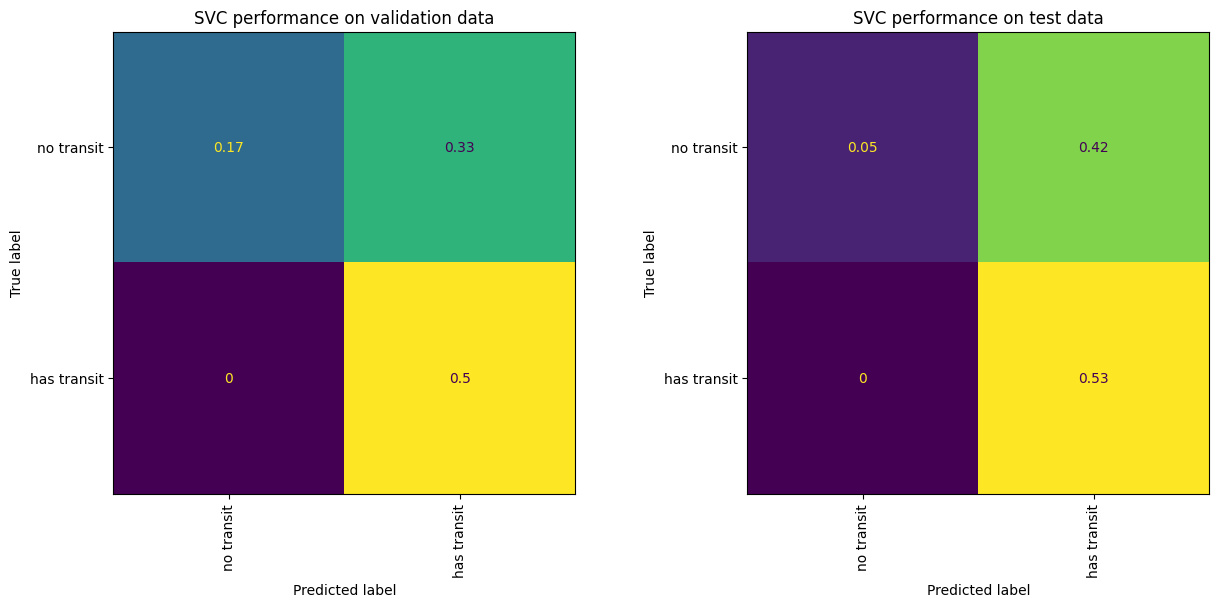

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax1 = plt.subplot(121)
ConfusionMatrixDisplay.from_estimator(clf, X_val_interp, y_val, xticks_rotation='vertical', ax=ax1, normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('SVC performance on validation data')
ax2 = plt.subplot(122)
ConfusionMatrixDisplay.from_estimator(clf, X_test_interp, y_test, xticks_rotation='vertical', ax=ax2, normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('SVC performance on test data')
plt.show()

In [37]:
print(classification_report(y_test, svc_pred_test))
print(f"Recall score is {recall_score(y_pred=svc_pred_test, y_true=y_test)}")

              precision    recall  f1-score   support

           0       1.00      0.11      0.19        19
           1       0.55      1.00      0.71        21

    accuracy                           0.57        40
   macro avg       0.78      0.55      0.45        40
weighted avg       0.77      0.57      0.46        40

Recall score is 1.0


### Use GridSearchCV to find optimal hyperparameter

In [22]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'poly']} 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100) # 10-fold cross validation
  
grid = GridSearchCV(SVC(), param_grid, refit = True, cv = folds, scoring='recall', verbose = 1, return_train_score=True, error_score='raise', n_jobs=-1)
  
# fitting the model for grid search
grid.fit(X_train_interp, y_train.ravel())

Fitting 10 folds for each of 75 candidates, totalling 750 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             error_score='raise', estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             return_train_score=True, scoring='recall', verbose=1)

In [23]:
# print best parameter after tuning
print(f"Best hyperparameter is: {grid.best_params_}")

# print how our model looks after hyper-parameter tuning
print(f"Best estimator is: {grid.best_estimator_}")

print(f"Best Validation recall score is: {grid.best_score_}")

Best hyperparameter is: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best estimator is: SVC(C=1, gamma=1)
Best Validation recall score is: 1.0


##### Results

In [25]:
svc_pred_test = grid.predict(X_test_interp)
svc_pred_train = grid.predict(X_train_interp)
print('train/validation accuracy:', np.round(accuracy_score(y_train , svc_pred_train),4))
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

train/validation accuracy: 0.5938
test accuracy: 0.575


<Figure size 1500x600 with 0 Axes>

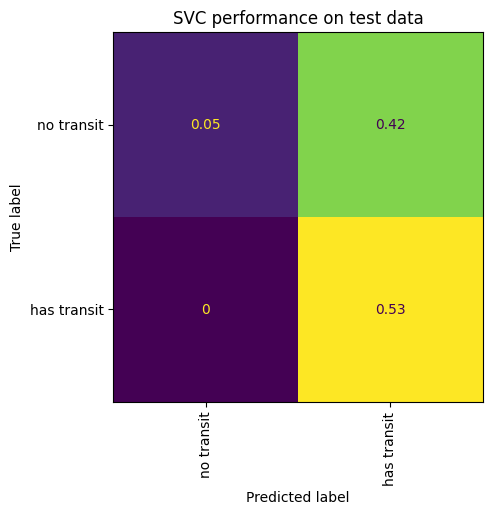

              precision    recall  f1-score   support

           0       1.00      0.11      0.19        19
           1       0.55      1.00      0.71        21

    accuracy                           0.57        40
   macro avg       0.78      0.55      0.45        40
weighted avg       0.77      0.57      0.46        40

Recall score is 1.0


In [26]:
# fig, ax = plt.subplots(1,2, figsize=(15,6))
plt.figure(figsize = [15,6])
ConfusionMatrixDisplay.from_estimator(grid, X_test_interp, y_test, xticks_rotation='vertical', normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('SVC performance on test data')
plt.show()

print(classification_report(y_test, svc_pred_test))
print(f"Recall score is {recall_score(y_pred=svc_pred_test, y_true=y_test)}")

## Use Phase-folded smooth data 

In [67]:
# from csv file created using utils.collect_curves_tofiles()
# all_curves = pd.read_csv('./Data/flux_phase_200_1000_50.csv', header = None)
# all_times = pd.read_csv('./Data/time_phase_200_1000_50.csv', header = None)
# all_labels = pd.read_csv('./Data/labels_phase_200_1000_50.csv', header = None)
all_curves = pd.read_csv('./Data/flux_phase_1000_1000_50.csv', header = None)
all_times = pd.read_csv('./Data/time_phase_1000_1000_50.csv', header = None)
all_labels = pd.read_csv('./Data/labels_phase_1000_1000_50.csv', header = None)
all_labels = np.array(all_labels).ravel()

X_train, X_test, y_train, y_test = train_test_split(all_curves, all_labels, test_size=0.2, random_state=321)

# fill in Nans
X_train_interp = X_train.interpolate(limit_direction='both', axis = 1)
X_test_interp = X_test.interpolate(limit_direction='both', axis = 1)

### Use GridSearchCV to find optimal hyperparameter

In [68]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid']} 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100) # 10-fold cross validation
  
# grid = GridSearchCV(SVC(), param_grid, refit = True, cv = folds, scoring='recall', verbose = 1, return_train_score=True, error_score='raise', n_jobs=-1)
grid = GridSearchCV(SVC(), param_grid, refit = True, cv = folds, scoring='accuracy', verbose = 1, return_train_score=True, error_score='raise', n_jobs=-1)
  
# fitting the model for grid search
grid.fit(X_train_interp, y_train.ravel())

Fitting 10 folds for each of 50 candidates, totalling 500 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             error_score='raise', estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [69]:
# print best parameter after tuning
print(f"Best hyperparameter is: {grid.best_params_}")

# print how our model looks after hyper-parameter tuning
print(f"Best estimator is: {grid.best_estimator_}")

print(f"Best Validation accuracy is: {grid.best_score_}")

Best hyperparameter is: {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
Best estimator is: SVC(C=1000, gamma=1)
Best Validation accuracy is: 0.5987500000000001


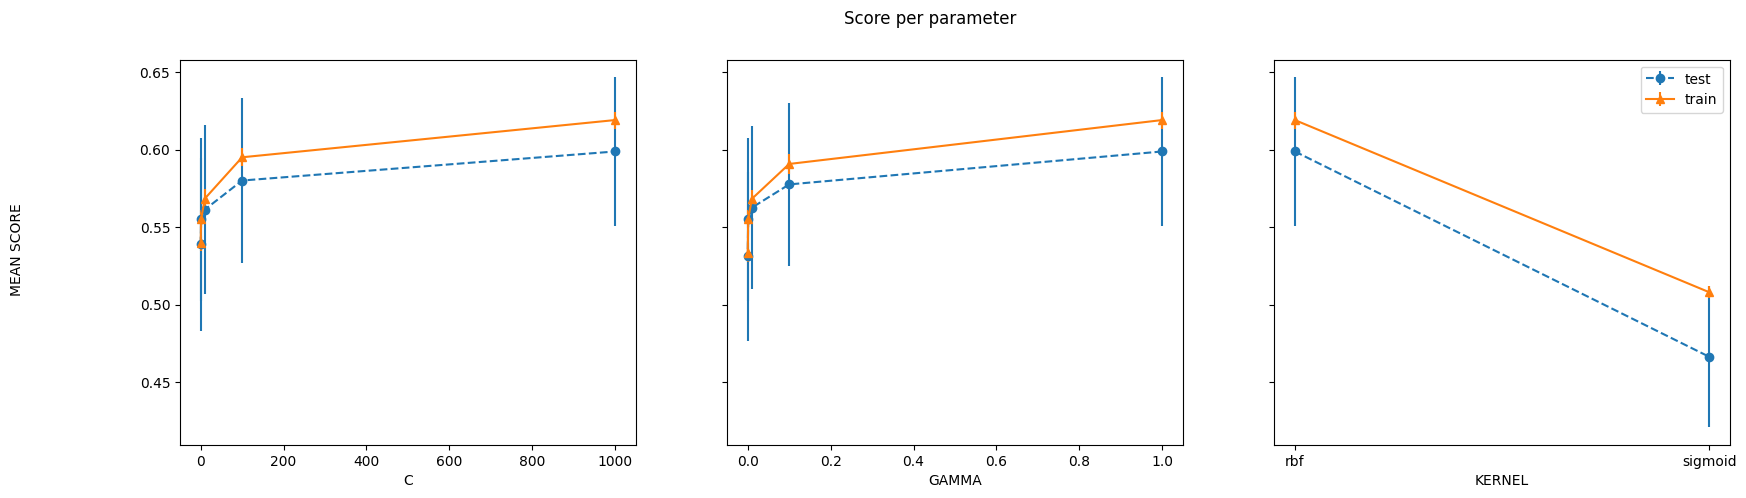

In [70]:
results = grid.cv_results_
means_test = results['mean_test_score']
stds_test = results['std_test_score']
means_train = results['mean_train_score']
stds_train = results['std_train_score']

## Getting indexes of values per hyper-parameter
masks=[]
masks_names= list(grid.best_params_.keys())
for p_k, p_v in grid.best_params_.items():
    masks.append(list(results['param_'+p_k].data==p_v))

params=grid.param_grid

## Ploting results
fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
fig.suptitle('Score per parameter')
fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
pram_preformace_in_best = {}
for i, p in enumerate(masks_names):
    m = np.stack(masks[:i] + masks[i+1:])
    pram_preformace_in_best
    best_parms_mask = m.all(axis=0)
    best_index = np.where(best_parms_mask)[0]
    x = np.array(params[p])
    y_1 = np.array(means_test[best_index])
    e_1 = np.array(stds_test[best_index])
    y_2 = np.array(means_train[best_index])
    e_2 = np.array(stds_train[best_index])
    ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
    ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
    ax[i].set_xlabel(p.upper())

plt.legend()
plt.show()

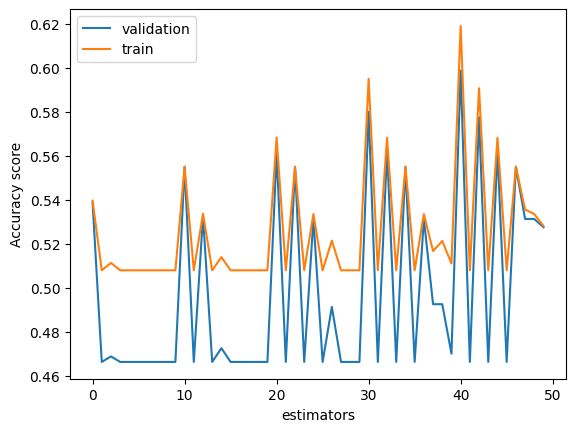

In [71]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='validation')
plt.plot(train_scores, label='train')
plt.xlabel('estimators')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.show()

##### Results

In [72]:
svc_pred_test = grid.predict(X_test_interp)
svc_pred_train = grid.predict(X_train_interp)
print('train/validation accuracy:', np.round(accuracy_score(y_train , svc_pred_train),4))
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

train/validation accuracy: 0.6175
test accuracy: 0.575


<Figure size 1500x600 with 0 Axes>

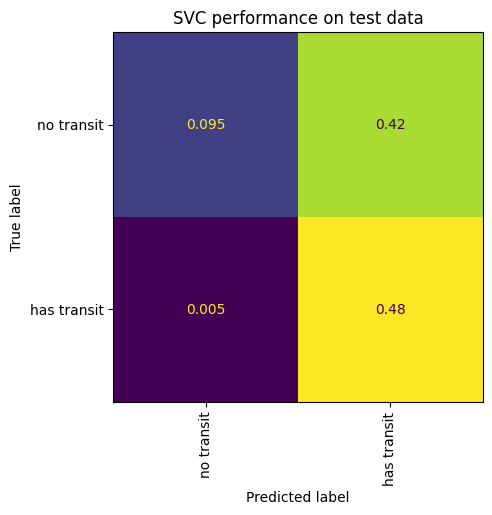

              precision    recall  f1-score   support

           0       0.95      0.18      0.31       103
           1       0.53      0.99      0.69        97

    accuracy                           0.57       200
   macro avg       0.74      0.59      0.50       200
weighted avg       0.75      0.57      0.50       200

Recall score is 0.9896907216494846


In [73]:
# fig, ax = plt.subplots(1,2, figsize=(15,6))
plt.figure(figsize = [15,6])
ConfusionMatrixDisplay.from_estimator(grid, X_test_interp, y_test, xticks_rotation='vertical', normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('SVC performance on test data')
plt.show()

print(classification_report(y_test, svc_pred_test))
print(f"Recall score is {recall_score(y_pred=svc_pred_test, y_true=y_test)}")

# Trying out Feature selection using RFE and SelectKBest

In [ ]:
from sklearn.feature_selection import RFE
hyper_params = [{'n_features_to_select': [500,750]}]

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
model = SVC(C=1000, gamma=1)
# model.fit(X_train_interp, y_train)
rfe = RFE(model)

model_cv2 = GridSearchCV(estimator = rfe, param_grid = hyper_params, scoring= 'accuracy', cv = folds,  verbose = 1, return_train_score=True, n_jobs=-1) 
model_cv2.fit(X_train_interp, y_train)

In [90]:
from sklearn.feature_selection import SelectKBest, f_classif

# selector = SelectKBest(f_classif, k=750) # test - 57
# selector = SelectKBest(f_classif, k=500) # test - 57
selector = SelectKBest(f_classif, k=900) # test - 57.5
selector.fit(X_train_interp, y_train)
print('Number of input features:', selector.n_features_in_)
# print('Input features scores :', selector.scores_)
# print('Input features pvalues:', selector.pvalues_)


X_train_selected = selector.transform(X_train_interp)
X_test_selected = selector.transform(X_test_interp)

X_train_selected.shape

Number of input features: 1000


(800, 900)

In [91]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid']} 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100) # 10-fold cross validation
  
# grid = GridSearchCV(SVC(), param_grid, refit = True, cv = folds, scoring='recall', verbose = 1, return_train_score=True, error_score='raise', n_jobs=-1)
grid = GridSearchCV(SVC(), param_grid, refit = True, cv = folds, scoring='accuracy', verbose = 1, return_train_score=True, error_score='raise', n_jobs=-1)
  
# fitting the model for grid search
grid.fit(X_train_selected, y_train.ravel())

Fitting 10 folds for each of 50 candidates, totalling 500 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             error_score='raise', estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [92]:
# print best parameter after tuning
print(f"Best hyperparameter is: {grid.best_params_}")

# print how our model looks after hyper-parameter tuning
print(f"Best estimator is: {grid.best_estimator_}")

print(f"Best Validation accuracy is: {grid.best_score_}")

Best hyperparameter is: {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
Best estimator is: SVC(C=1000, gamma=1)
Best Validation accuracy is: 0.5962500000000002


In [93]:
svc_pred_test = grid.predict(X_test_selected)
svc_pred_train = grid.predict(X_train_selected)
print('train/validation accuracy:', np.round(accuracy_score(y_train , svc_pred_train),4))
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

train/validation accuracy: 0.615
test accuracy: 0.575
